In [5]:
from ibis.interactive import *
from plotnine import *

In [9]:
!test -e reviews.json || gh pr list --limit 1000 --state all --json reviews,closedAt,mergedAt,createdAt,number,additions,deletions,changedFiles,url | sed -e 's/\x1b\[[0-9;]*m//g' > reviews.json

HTTP 504: We couldn't respond to your request in time. Sorry about that. Please try resubmitting your request and contact us if the problem persists. (https://api.github.com/graphql)


In [3]:
t = (
    ibis.read_json("reviews.json")
    .mutate(resolvedAt=_.mergedAt.coalesce(_.closedAt))
    .filter(_.resolvedAt.notnull())
    .mutate(
        tt_rev=_.reviews[0].submittedAt.delta(_.createdAt, unit="days"),
        tt_cls=_.closedAt.delta(_.createdAt, unit="days"),
        tt_mrg=_.mergedAt.delta(_.createdAt, unit="days"),
        tt_fin=_.closedAt.delta(_.reviews[-1].submittedAt, unit="days").clip(lower=-1).nullif(-1),
        total_changes=_.additions + _.deletions,
    )
    .pivot_longer(s.startswith("tt_"), names_to="metric", values_to="duration")
    .filter(_.duration >= 0)
    .mutate(
        p95=_.duration.quantile(0.95).over(group_by="metric"),
        p99=_.duration.quantile(0.99).over(group_by="metric"),
    )
)
t

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ closedAt            ┃ createdAt           ┃ mergedAt            ┃ number ┃ reviews                                                                          ┃ url                                             ┃ resolvedAt          ┃ metric ┃ duration ┃ p95     ┃ p99     ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ timestamp(6)        │ timestamp(6)        │ timestamp(6)        │ int64  │ array<struct<id: string, author: struct<login: string>, authorAssociation: stri… │ string                                          │ timestamp(6)        │ string │ int64    │ float64 │ float64 │
├─────────────────────┼─────────────────────┼─────────────────────┼────────┼──────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────────────────────┼─────────────────────┼────────┼──────────┼─────────┼─────────┤
│ 2025-11-11 15:42:20 │ 2025-11-11 12:58:07 │ 2025-11-11 15:42:20 │   1232 │ [{...}]                                                                          │ ]8;id=938026;https://github.com/NVIDIA/cuda-python/pull/1232\https://github.com/NVIDIA/cuda-python/pull/1232]8;;\ │ 2025-11-11 15:42:20 │ tt_rev │        0 │     9.7 │   44.67 │
│ 2025-11-11 02:55:18 │ 2025-11-10 02:14:37 │ 2025-11-11 02:55:18 │   1229 │ [{...}, {...}, ... +6]                                                           │ ]8;id=993276;https://github.com/NVIDIA/cuda-python/pull/1229\https://github.com/NVIDIA/cuda-python/pull/1229]8;;\ │ 2025-11-11 02:55:18 │ tt_rev │        0 │     9.7 │   44.67 │
│ 2025-11-10 18:51:19 │ 2025-11-07 21:22:01 │ 2025-11-10 18:51:19 │   1224 │ [{...}, {...}, ... +15]                                                          │ ]8;id=21497;https://github.com/NVIDIA/cuda-python/pull/1224\https://github.com/NVIDIA/cuda-python/pull/1224]8;;\ │ 2025-11-10 18:51:19 │ tt_rev │        3 │     9.7 │   44.67 │
│ 2025-11-07 19:10:39 │ 2025-11-07 00:06:11 │ 2025-11-07 19:10:39 │   1221 │ [{...}, {...}, ... +1]                                                           │ ]8;id=847756;https://github.com/NVIDIA/cuda-python/pull/1221\https://github.com/NVIDIA/cuda-python/pull/1221]8;;\ │ 2025-11-07 19:10:39 │ tt_rev │        0 │     9.7 │   44.67 │
│ 2025-11-05 19:58:04 │ 2025-11-05 17:25:45 │ 2025-11-05 19:58:04 │   1219 │ [{...}, {...}]                                                                   │ ]8;id=955436;https://github.com/NVIDIA/cuda-python/pull/1219\https://github.com/NVIDIA/cuda-python/pull/1219]8;;\ │ 2025-11-05 19:58:04 │ tt_rev │        0 │     9.7 │   44.67 │
│ 2025-11-07 18:45:44 │ 2025-11-03 23:55:01 │ 2025-11-07 18:45:44 │   1210 │ [{...}]                                                                          │ ]8;id=193581;https://github.com/NVIDIA/cuda-python/pull/1210\https://github.com/NVIDIA/cuda-python/pull/1210]8;;\ │ 2025-11-07 18:45:44 │ tt_rev │        4 │     9.7 │   44.67 │
│ 2025-11-04 20:35:01 │ 2025-11-03 20:37:18 │ 2025-11-04 20:35:01 │   1209 │ [{...}, {...}, ... +1]                                                           │ ]8;id=396757;https://github.com/NVIDIA/cuda-python/pull/1209\https://github.com/NVIDIA/cuda-python/pull/1209]8;;\ │ 2025-11-04 20:35:01 │ tt_rev │        0 │     9.7 │   44.67 │
│ 2025-11-01 21:17:02 │ 2025-11-01 16:18:50 │ 2025-11-01 21:17:02 │   1206 │ [{...}]                                                                          │ ]8;id=499816;https://github.com/NVIDIA/cuda-python/pull/1206\https://github.com/NVIDI

In [4]:
import logging

import numpy

# without this, findfont logging spams the notebook making it unusable
logging.getLogger("matplotlib.font_manager").disabled = True
logging.getLogger("plotnine").disabled = True
numpy.seterr(divide="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

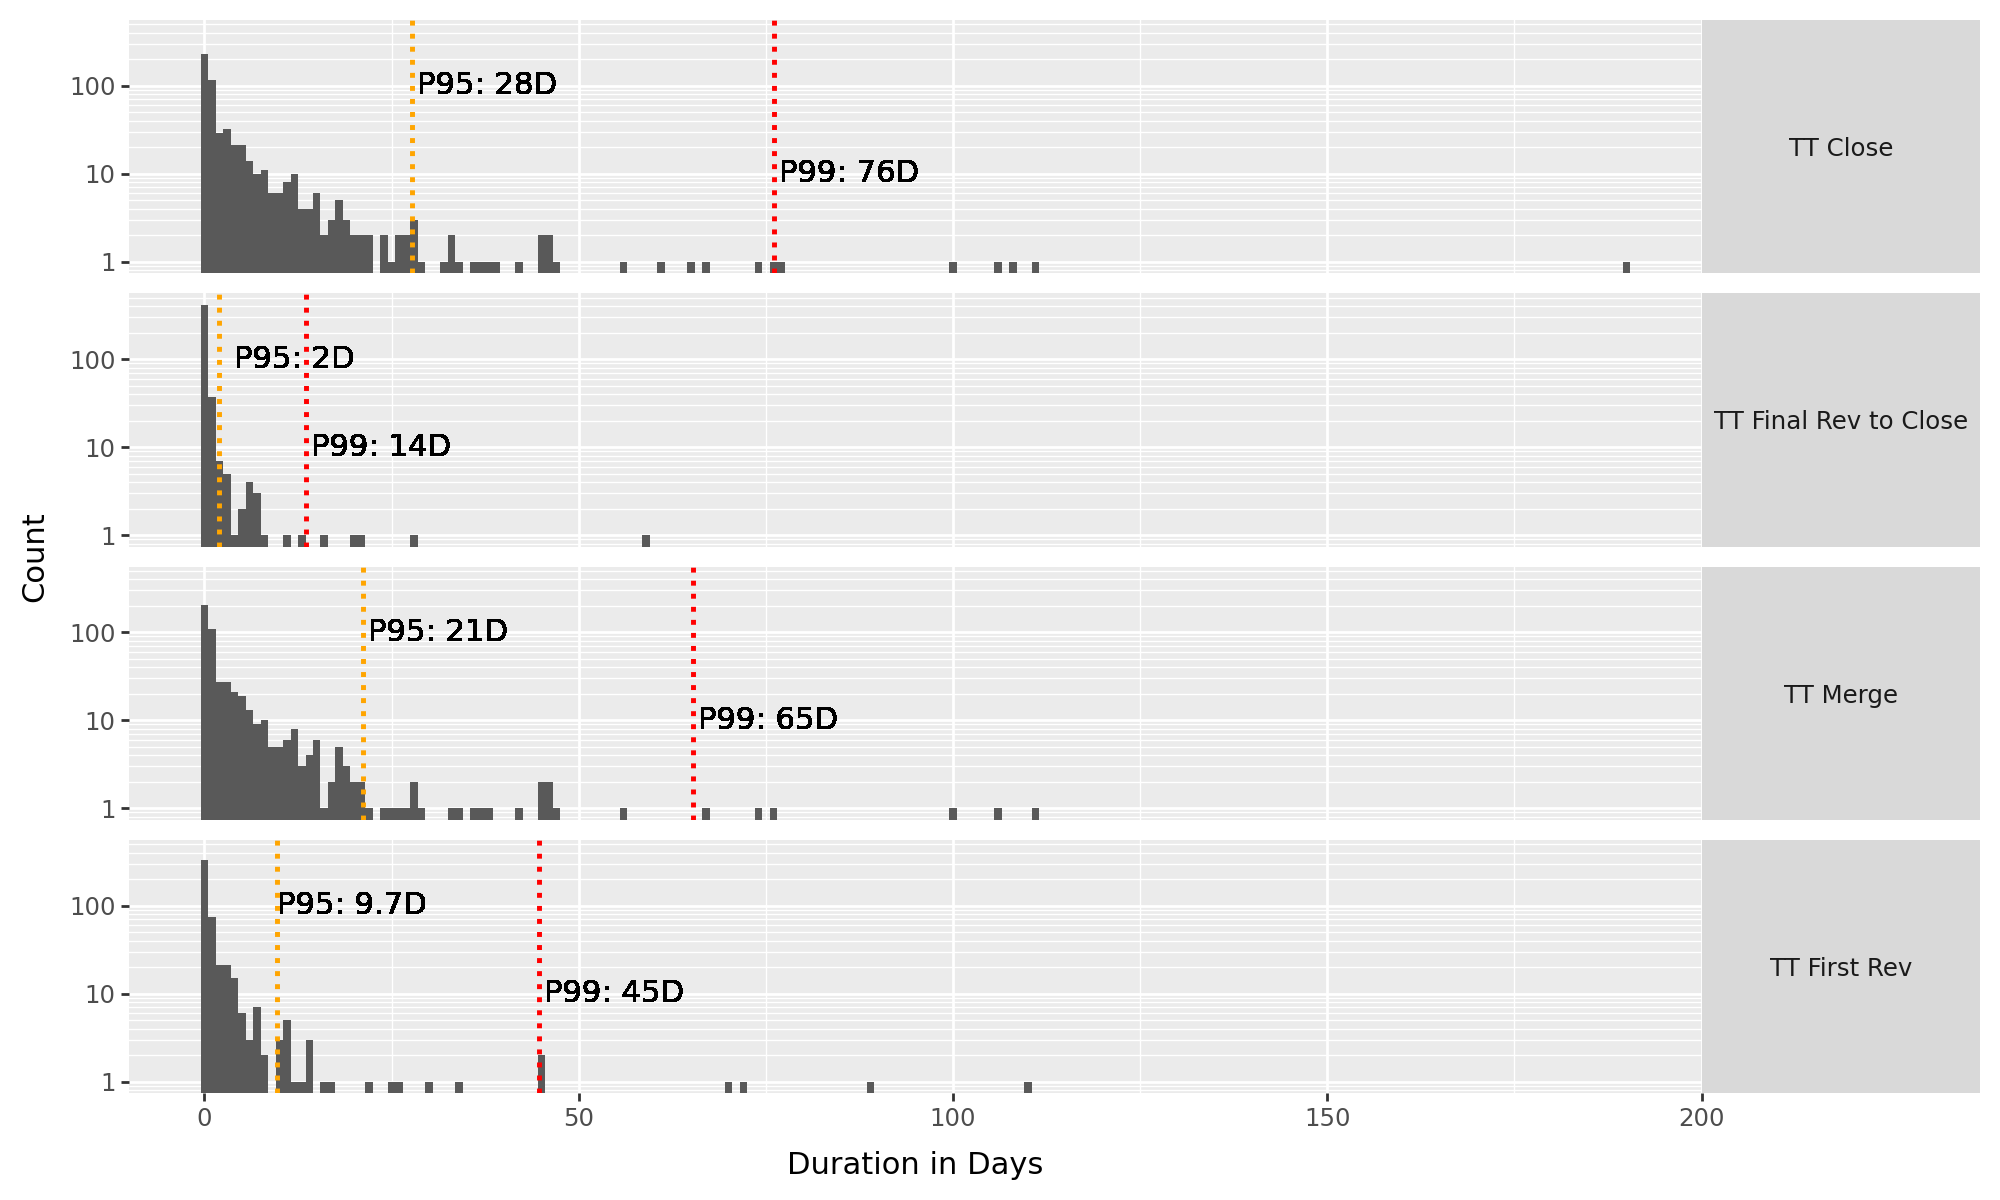

In [5]:
size = 1
linetype = "dotted"
show_legend = True

LABELS = {
    "tt_cls": "TT Close",
    "tt_mrg": "TT Merge",
    "tt_rev": "TT First Rev",
    "tt_fin": "TT Final Rev to Close",
}

labeller = LABELS.__getitem__

(
    ggplot(t, aes(x="duration"))
    + geom_histogram(binwidth=1)
    + geom_vline(aes(xintercept="p95"), color="orange", size=size, linetype=linetype)
    + geom_vline(aes(xintercept="p99"), color="red", size=size, linetype=linetype)
    + geom_text(aes(x="p95", y=100, label="p95"), nudge_x=10, format_string="P95: {:.2g}D")
    + geom_text(aes(x="p99", y=10, label="p99"), nudge_x=10, format_string="P99: {:.2g}D")
    + scale_y_log10()
    + facet_grid("metric", labeller=labeller)
    + theme(
        strip_text_y=element_text(angle=0),
        figure_size=(10, 6),
    )
    + labs(x="Duration in Days", y="Count")
)

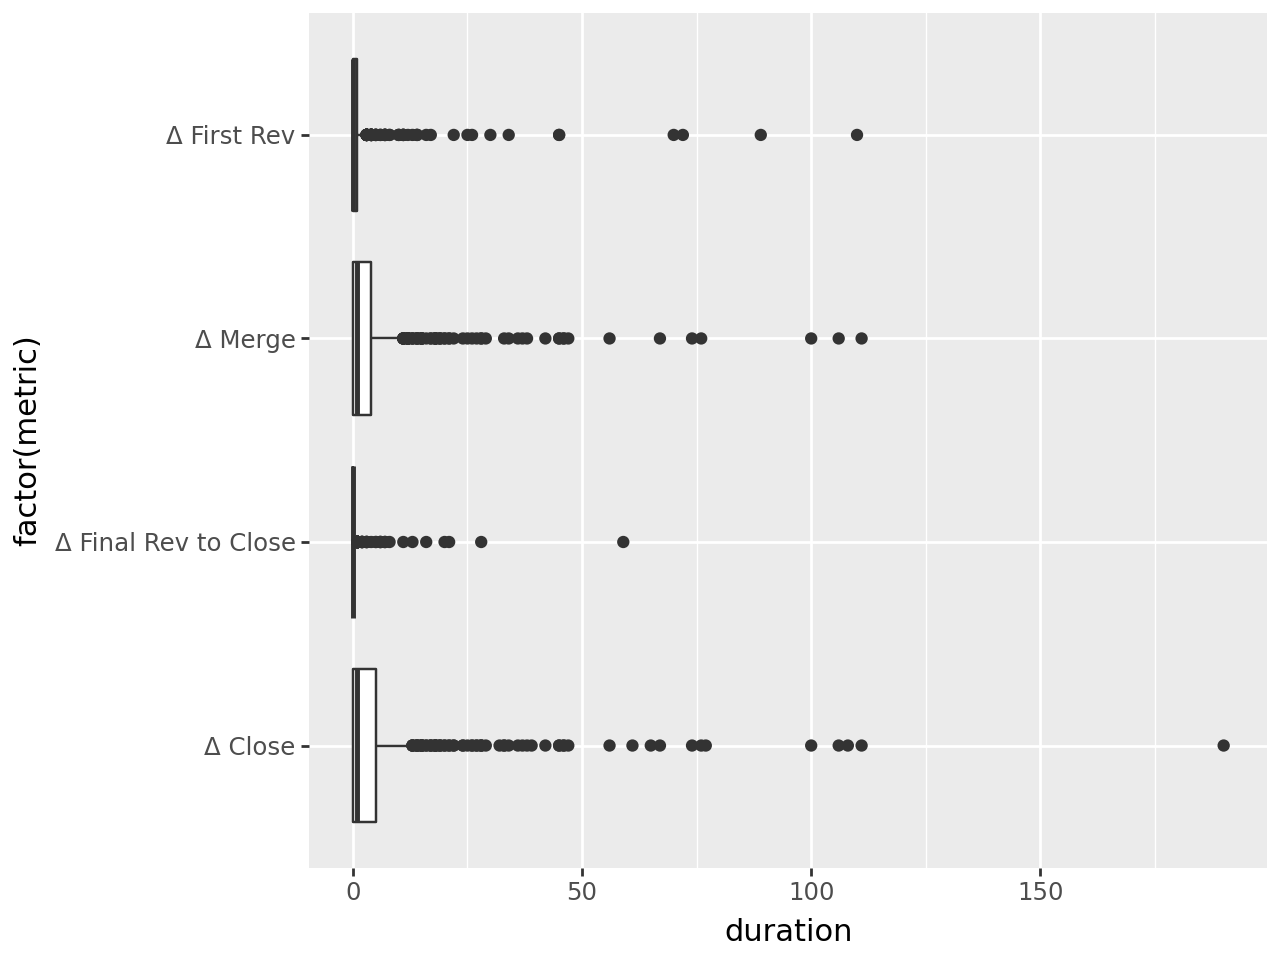

In [6]:
(
    ggplot(t, aes(x="factor(metric)", y="duration"))
    + coord_flip()
    + geom_boxplot()
    + scale_x_discrete(labels=reversed(["Δ First Rev", "Δ Merge", "Δ Final Rev to Close", "Δ Close"]))
)